DecisionTreeClassifier（決定木で推測してみる）

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

import collections

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Duplicate key in file WindowsPath('C:/Users/GuestUser/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  IPAexGothic')


データを変数に入れる

In [3]:
train = pd.read_table('train.tsv')
test = pd.read_csv('test.tsv',sep='\t')
sample = pd.read_csv('sample_submit.csv',header=None)

データを整える　※native-countryについて、trainかtest片方にしかないものは？に変換してしまう。

In [5]:
train = train.replace({"Y":{"<=50K" : 0, ">50K" : 1}})
train["Y"].value_counts()

0    12288
1     3992
Name: Y, dtype: int64

In [6]:
trainX = train.iloc[:,0:15]
y = train["Y"]
testX = test.copy()

In [7]:
train = train.drop(columns=["id","education"])
trainX = trainX.drop(columns=["id","education"])
testX = testX.drop(columns=["id","education"])

In [8]:
indexNum = testX[~testX["native-country"].isin(trainX["native-country"].unique())].index
for i in indexNum:
    testX.iat[i,12] = "?"
    print(testX.iat[i,12])

?


決定木モデル作成

In [21]:
trainX = pd.get_dummies(trainX)
testX = pd.get_dummies(testX)

In [22]:
clf1 = DT()

In [30]:
parameters2 = {"max_depth":list(range(2,16)), "min_samples_leaf":[5,10,20,50,100,500]}

In [31]:
gcv2 = GridSearchCV(clf1, parameters2, cv=5, scoring="roc_auc",n_jobs=-1,return_train_score=True)
gcv2.fit(trainX,y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [32]:
gcv2.best_params_

{'max_depth': 10, 'min_samples_leaf': 100}

In [33]:
trainXpred = gcv2.predict_proba(trainX)
trainXpred = trainXpred[:,1]
trainXl = len(trainXpred)
trainXpred = trainXpred.astype(object)
trainXpred

array([0.011004126547455296, 0.33157894736842103, 0.5, ...,
       0.02967032967032967, 0.0, 0.1016949152542373], dtype=object)

In [34]:
y

0        0
1        0
2        1
3        0
4        1
5        1
6        1
7        0
8        0
9        1
10       0
11       0
12       1
13       0
14       0
15       0
16       1
17       0
18       0
19       1
20       1
21       1
22       0
23       1
24       0
25       0
26       1
27       0
28       0
29       0
30       0
31       0
32       1
33       0
34       1
35       0
36       0
37       0
38       1
39       0
40       1
41       0
42       0
43       0
44       1
45       1
46       0
47       0
48       1
49       1
50       0
51       1
52       0
53       0
54       1
55       0
56       0
57       0
58       0
59       0
60       0
61       0
62       0
63       0
64       0
65       0
66       1
67       0
68       0
69       0
70       0
71       0
72       1
73       0
74       0
75       0
76       1
77       1
78       0
79       1
80       0
81       0
82       0
83       0
84       0
85       0
86       1
87       0
88       1
89       1
90       0

In [35]:
ansRateList = pd.DataFrame()
for j in range(10):
    c = trainXpred.copy()
    n = (35+5*j)/100
    for i in range(trainXl):
        if c[i] <= n:
            c[i] = 0
        else:
            c[i] = 1
    ansRateBase = np.equal(c,y)
    ansRate = collections.Counter(ansRateBase)[True]/len(ansRateBase)
    ansRateData = pd.DataFrame([[n,ansRate]])
    ansRateList = pd.concat([ansRateList,ansRateData],ignore_index=True)
ansRateList

,0,1
0,0.35,0.837899
1,0.40,0.850307
2,0.45,0.853378
3,0.50,0.853563
4,0.55,0.852211
5,0.60,0.851474
6,0.65,0.851474
7,0.70,0.844902
8,0.75,0.840049
9,0.80,0.829300


([<matplotlib.axis.XTick at 0x1455c456eb0>,
 [Text(0, 0, '0.35'),
  Text(1, 0, '0.4'),
  Text(2, 0, '0.45'),
  Text(3, 0, '0.5'),
  Text(4, 0, '0.55'),
  Text(5, 0, '0.6'),
  Text(6, 0, '0.65'),
  Text(7, 0, '0.7'),
  Text(8, 0, '0.75'),
  Text(9, 0, '0.8')])

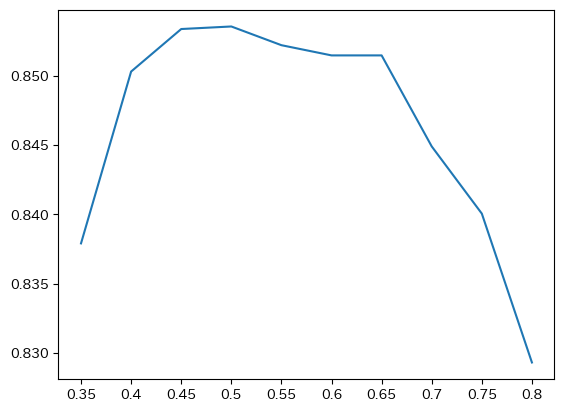

In [42]:
plt.plot(ansRateList[1])
plt.xticks([0,1,2,3,4,5,6,7,8,9],ansRateList[0])

予測に代入して結果を出力する

In [43]:
pred = gcv2.predict_proba(testX)

In [44]:
pred = pred[:,1]
l = len(pred)

In [45]:
pred = pred.astype(object)
for i in range(l):
    if pred[i] <= 0.5:
        pred[i] = "<=50K"
    else:
        pred[i] = ">50K"

In [46]:
sample[1] = pred

In [47]:
sample.to_csv("submit2_1.csv",index=None,header=None)